<img src="https://github.com/KartikNW/MSDS_458_Public/blob/main/images2/NorthwesternHeader.png?raw=1" />

# Assignment 01 – Diamonds Ensemble Modeling

In this assignment, you will explore an advanced **ensemble modeling approach** that combines multiple specialized models to predict diamond prices based on price tiers.

## What You'll Learn

This notebook demonstrates how to build a sophisticated two-stage prediction system. You will:

- Split diamonds into **price tiers** (low, medium, high) and train a specialized regression model for each tier
- Train a **neural network classifier** to predict which price tier a diamond belongs to
- Combine the classifier and tier-specific regressors into a **unified ensemble system** using the `ensemble_framework.py` module
- Evaluate the ensemble on truly held-out test data and compare performance against baseline and SMOTE approaches

## Key Difference from Basic Regression and SMOTE

Unlike previous approaches where a single model predicts all prices, this ensemble uses a **two-stage process**:

1. **Stage 1 - Classification**: Predict which price tier the diamond belongs to (low/medium/high)
2. **Stage 2 - Regression**: Route to the appropriate tier-specific model for exact price prediction

By training separate models for each price range, each model can specialize in patterns specific to its tier rather than trying to learn all patterns simultaneously. This can lead to better predictions, especially for underrepresented expensive diamonds.

> **Note:** This is an advanced approach. You will evaluate whether the increased model complexity provides better performance compared to the simpler approaches from previous notebooks.

## Import Required Libraries

In this section, we import the essential Python libraries needed for data manipulation, visualization, and building deep learning models.  

- **Pandas** and **NumPy** are used for data handling and numerical computations.  
- **Matplotlib** and **Seaborn** help visualize feature distributions and model performance.  
- **TensorFlow** and **Keras** are used to construct, train, and evaluate the neural network regression model.  
- Private helper modules, **`diamonds_utils.py`** and **`ensemble_framework.py`**, are also imported. These modules contain utility functions that simplify repetitive tasks such as data preprocessing, visualization, and evaluation—making the notebook cleaner and easier to follow.  

> ⚠️ **Note:** The `diamonds_utils.py` and `ensemble_framework.py` files are not part of the standard library and must be downloaded from the course GitHub repository before running this notebook.





In [ ]:
import os, sys, importlib.util, urllib.request

IN_COLAB = 'google.colab' in sys.modules
UTILS_PATH = 'diamonds_utils.py'
ENSEMBLE_FRAMEWORK_PATH = 'ensemble_framework.py'

def fetch_github_raw(user, repo, branch, file_path, local_path):
    url = f"https://raw.githubusercontent.com/{user}/{repo}/{branch}/{file_path}"
    urllib.request.urlretrieve(url, local_path)
    print(f"Fetched {file_path} from branch '{branch}'.")

if IN_COLAB:
    # Check if either file is missing
    utils_missing = not os.path.exists(UTILS_PATH)
    ensemble_missing = not os.path.exists(ENSEMBLE_FRAMEWORK_PATH)

    if utils_missing or ensemble_missing:
        print("Running in Colab. Fetching missing project files…")
        
        if utils_missing:
            fetch_github_raw("kartikNW", "MSDS_458_Public", "future", 
                     "MSDS458_Assignment_01/diamonds_utils.py", UTILS_PATH)
        
        if ensemble_missing:
            fetch_github_raw("kartikNW", "MSDS_458_Public", "future", 
                     "MSDS458_Assignment_01/ensemble_framework.py", ENSEMBLE_FRAMEWORK_PATH)
            
        print("Project files successfully fetched.")
    else:
        print("Using existing project files in Colab.")
else:
    # This is the message you saw in your error log
    print("Using local project files.")

Using local project files.


In [2]:
# Set the environment variable to disable GPU
os.environ['DIAMONDS_DISABLE_GPU'] = '1'

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from packaging import version
from diamonds_utils import (
    load_data,
    display_data_info,
    analyze_categorical_variables,
    analyze_price_distribution,
    analyze_carat_price_relationship,
    analyze_cut_impact,
    analyze_correlations,
    create_price_tiers,
    prepare_data,
    prepare_data_without_split,
    split_data,
    train_model,
    create_classifier_model,
    plot_training_history,
    plot_percentage_error_by_price,
    evaluate_model,
    residual_plot,
    remove_specific_outliers,
    apply_smote
)
import ensemble_framework as ef

/Users/kartikshridhar/gitrepos/personal/MSDS_458_Collab/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Version Requirements

This assignment requires recent versions of **Python** and **TensorFlow/Keras** to ensure compatibility with the neural network code.  

| Library | Minimum Version | Purpose |
|----------|------------------|----------|
| Python | 3.10 | Core language |
| TensorFlow / Keras | 2.15 | Deep learning framework |

If you're running this notebook locally, you can verify your setup using the code cell below.


In [4]:
print("Python version:", sys.version.split()[0])
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

# Minimum version requirements
min_versions = {
    "Python": "3.10",
    "TensorFlow": "2.15",
    "Keras": "3.0",
}

def check_version(name, current, minimum):
    if version.parse(current) < version.parse(minimum):
        print(f"⚠️ {name} version {current} < required {minimum}. Please upgrade.")

check_version("Python", sys.version.split()[0], min_versions["Python"])
check_version("TensorFlow", tf.__version__, min_versions["TensorFlow"])
check_version("Keras", tf.keras.__version__, min_versions["Keras"])

Python version: 3.9.6
TensorFlow version: 2.19.0
Keras version: 3.10.0
⚠️ Python version 3.9.6 < required 3.10. Please upgrade.


## Load and Display Data

First, you will load the diamonds dataset and display its basic information. This is the same dataset used in the previous assignments, containing **53,940 diamonds** with features like carat, cut, color, clarity, and price.

In this notebook, you will focus on how **splitting the data into price tiers** and training specialized models for each tier is a third approach to try and improve accuracy.

In [5]:
# Load the dataset
diamonds = load_data()

# Display basic information
display_data_info(diamonds)


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   carat    53940 non-null  float64 
 1   cut      53940 non-null  category
 2   color    53940 non-null  category
 3   clarity  53940 non-null  category
 4   depth    53940 non-null  float64 
 5   table    53940 non-null  float64 
 6   price    53940 non-null  int64   
 7   x        53940 non-null  float64 
 8   y        53940 non-null  float64 
 9   z        53940 non-null  float64 
dtypes: category(3), float64(6), int64(1)
memory usage: 3.0 MB
None

First 5 rows of the dataset:
   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I   

## Create Price Tiers and Split Data

In this section, you will create three price tiers (low, medium, high) and visualize their distribution. You'll use thresholds of **$2,500** and **$6,000** to split the diamonds into relatively balanced groups.

### Critical Implementation Step

**IMPORTANT**: You will split the **full dataset into train/test sets FIRST** (80/20 split) before creating price tiers. This ensures you have truly unseen data for final ensemble evaluation. The test set will remain completely untouched during model training.

- **Training set**: Used to train tier-specific models and the classifier
- **Test set**: Held out for unbiased ensemble evaluation at the end

This approach prevents data leakage and gives you an honest assessment of how the ensemble performs on new diamonds.

### Visualizing Price Tiers

After creating the tiers, you'll see a histogram showing how diamonds are distributed across the three price ranges. Notice how the distribution is naturally imbalanced, with more diamonds in lower price ranges - this is exactly why specialized models for each tier can be beneficial.

price_tier
low       27540
medium    14849
high      11551
Name: count, dtype: int64


<Axes: xlabel='price', ylabel='Count'>

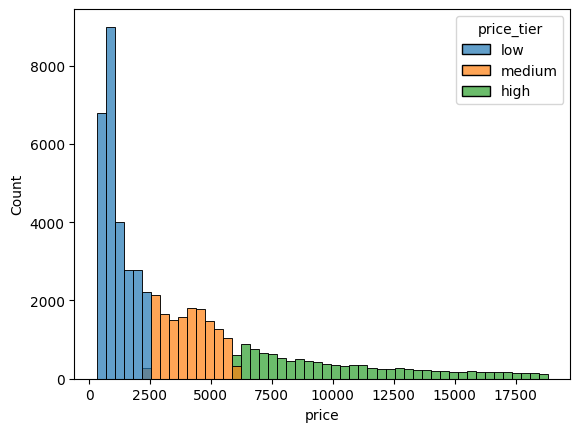

In [6]:
# Split the data using price tiers
diamonds_tiers = create_price_tiers(diamonds, low_threshold=2500, high_threshold=6000)
print(diamonds_tiers['price_tier'].value_counts())

# histogram of the price tiers
import seaborn as sns
import tensorflow as tf
sns.histplot(data=diamonds_tiers, x='price', hue='price_tier', bins=50, alpha=0.7)

In [7]:
# remove outliers from the dataset
diamonds = remove_specific_outliers(diamonds)

# IMPORTANT: Split the FULL dataset into train/test FIRST (before tiering)
# This ensures we have truly unseen data for ensemble evaluation
from sklearn.model_selection import train_test_split
diamonds_train, diamonds_test = train_test_split(diamonds, test_size=0.2, random_state=42)

print(f"Training set: {len(diamonds_train)} rows")
print(f"Test set: {len(diamonds_test)} rows")

Before removing specific outliers: (53940, 10)
After removing specific outliers: (53916, 10)
Removed 24 rows (0.04% of data)

Removal Summary:
- Zero dimensions (x=0, y=0, z=0): 35 rows
- Table = 95: 1 rows
- Y = 31.8: 1 rows
- Y = 58.9: 1 rows
- Z = 31.8: 1 rows
Training set: 43132 rows
Test set: 10784 rows


### Split data into tiers
Note: We'll need to add split_data to the imports or handle the splitting differently

In [8]:
low_data, medium_data, high_data = split_data(diamonds_train, low_threshold=2500, high_threshold=6000)

## Train Tier-Specific Regression Models

Now you will train **three separate neural network regression models**, one for each price tier. Each model will specialize in predicting prices within its specific range:

- **Low tier model**: Trained only on diamonds < $2,500
- **Medium tier model**: Trained only on diamonds between $2,500 - $6,000  
- **High tier model**: Trained only on diamonds > $6,000

### Why Train Separate Models?

Each price tier has distinct characteristics. By training separate models:
- Each model learns patterns specific to its price range
- Models aren't distracted by patterns from other tiers
- Rare expensive diamonds get dedicated modeling attention

### What to Observe

As you train each model, pay attention to:
- How training/validation loss differs across tiers
- Whether some tiers converge faster than others
- The size of each training set (some tiers have fewer samples)

You'll use the same neural network architecture for all three models to ensure fair comparison.



=== Training LOW tier model ===
Epoch 1/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 1s 583us/step - loss: 924977.5000 - mae: 723.9181 - mape: 62.0256 - val_loss: 43077.4102 - val_mae: 154.2722 - val_mape: 14.7218
Epoch 2/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 36622.5898 - mae: 142.0374 - mape: 13.6025 - val_loss: 29841.2656 - val_mae: 126.5240 - val_mape: 11.8187
Epoch 3/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step - loss: 26412.3086 - mae: 119.7745 - mape: 11.2561 - val_loss: 25742.5605 - val_mae: 116.6151 - val_mape: 10.7828
Epoch 4/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 22803.8789 - mae: 110.3781 - mape: 10.4143 - val_loss: 23612.1562 - val_mae: 111.6816 - val_mape: 10.3293
Epoch 5/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 22605.5078 - mae: 108.8807 - mape: 10.1034 - val_loss: 22602.7324 - val_mae: 107.8005 - val_mape: 9.9219
Epoch 6/50
441/441 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 21267.0488 - mae: 106.2263 - mape: 9.8805 - val_loss: 22346.0371 

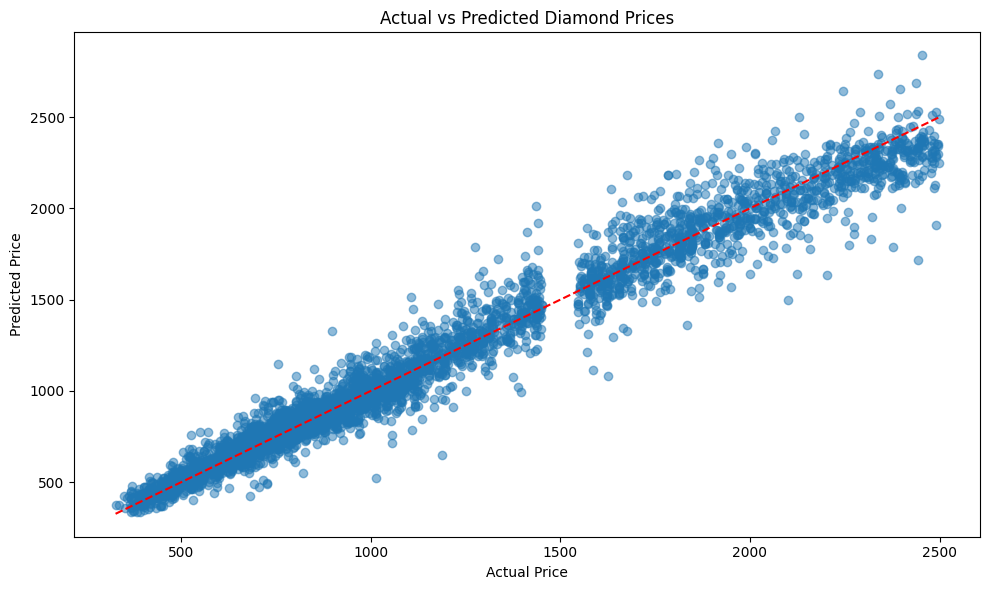

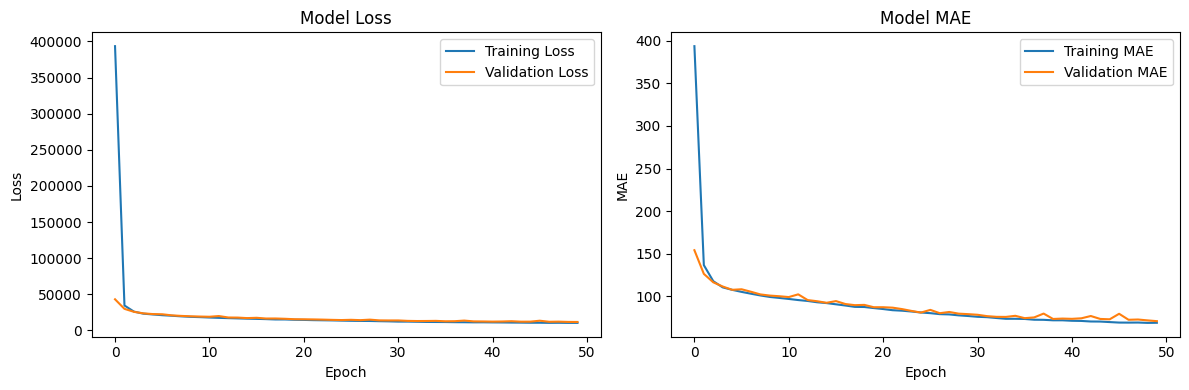

=== LOW tier complete ===


=== Training MEDIUM tier model ===
Epoch 1/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 14715786.0000 - mae: 3584.4329 - mape: 87.3673 - val_loss: 633051.6875 - val_mae: 598.3806 - val_mape: 14.7981
Epoch 2/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 551858.3750 - mae: 553.2977 - mape: 13.9839 - val_loss: 439464.3750 - val_mae: 502.4657 - val_mape: 12.8072
Epoch 3/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 517us/step - loss: 395105.4688 - mae: 473.7397 - mape: 12.1906 - val_loss: 367462.3125 - val_mae: 465.6278 - val_mape: 11.9636
Epoch 4/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 330396.9062 - mae: 434.7708 - mape: 11.1481 - val_loss: 313662.6875 - val_mae: 432.2571 - val_mape: 11.0053
Epoch 5/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 280807.0625 - mae: 403.1833 - mape: 10.3026 - val_loss: 267461.7812 - val_mae: 400.8899 - val_mape: 10.2192
Epoch 6/50
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 255695.7812 - mae: 384

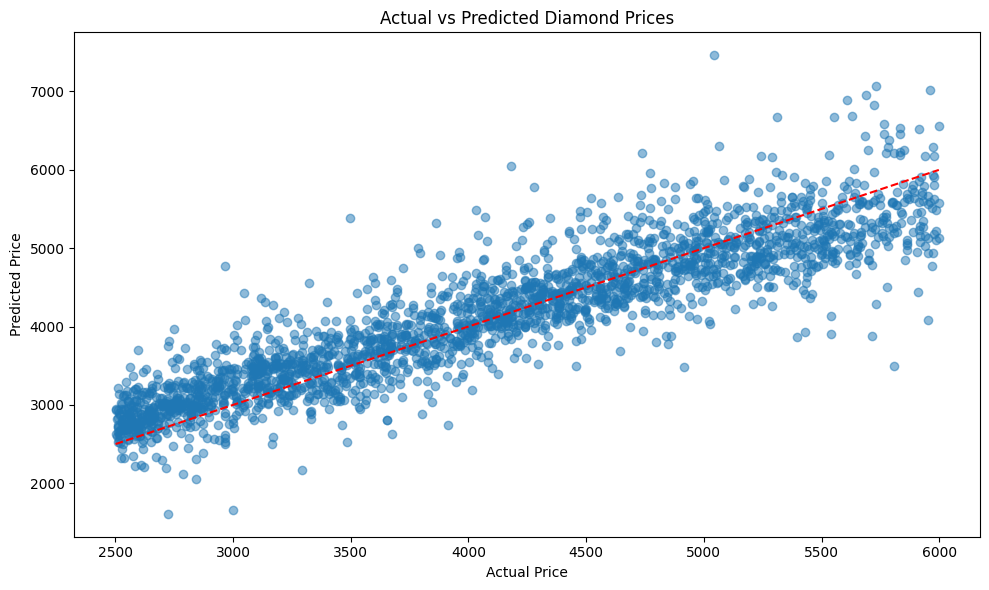

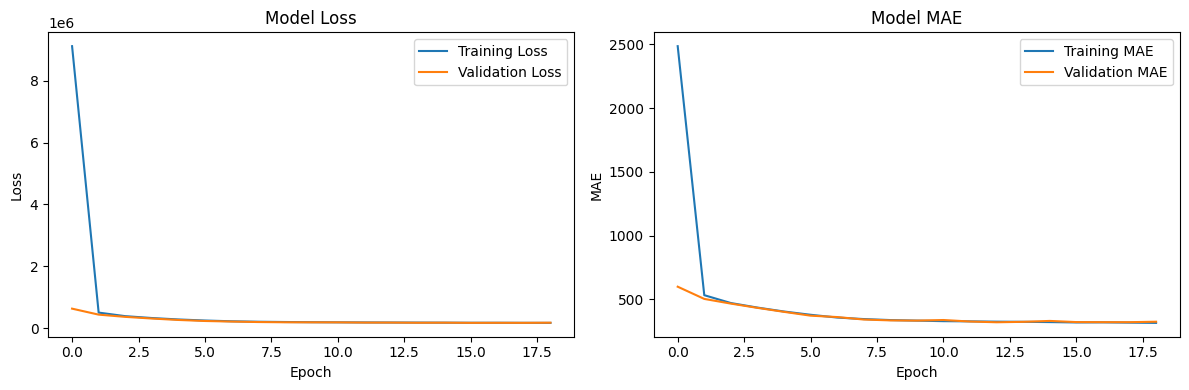

=== MEDIUM tier complete ===


=== Training HIGH tier model ===
Epoch 1/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - loss: 116391656.0000 - mae: 10185.7529 - mape: 97.8775 - val_loss: 30932048.0000 - val_mae: 4899.6670 - val_mape: 44.7009
Epoch 2/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 12916114.0000 - mae: 2706.2461 - mape: 24.8802 - val_loss: 5801432.5000 - val_mae: 1795.8887 - val_mape: 17.4335
Epoch 3/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 5274744.0000 - mae: 1689.1191 - mape: 16.6686 - val_loss: 4628178.0000 - val_mae: 1578.9382 - val_mape: 15.6334
Epoch 4/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 4339942.5000 - mae: 1494.9248 - mape: 14.8347 - val_loss: 4026828.0000 - val_mae: 1421.1140 - val_mape: 14.1090
Epoch 5/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 3943875.7500 - mae: 1376.4258 - mape: 13.6146 - val_loss: 3704926.2500 - val_mae: 1342.8862 - val_mape: 12.8806
Epoch 6/50
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss:

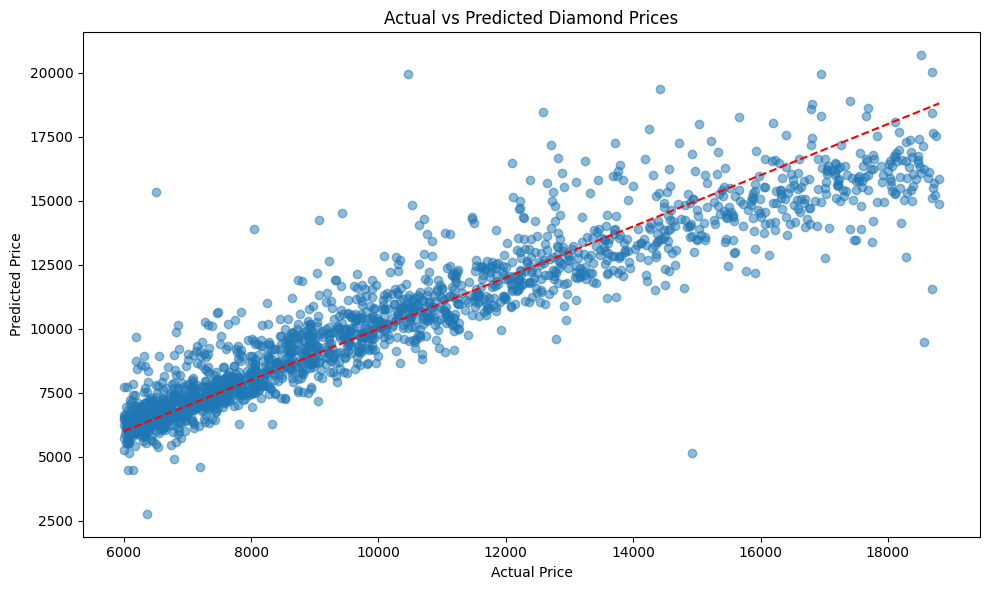

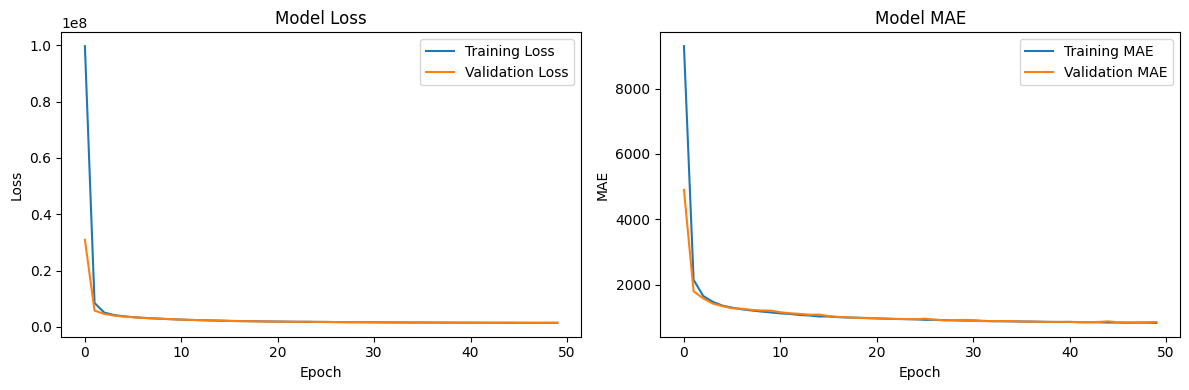

=== HIGH tier complete ===

All models trained successfully!

✅ IMPORTANT: diamonds_test (rows) is kept completely separate for ensemble evaluation


In [9]:
# Define features (same for all tiers)
numerical_features = ['carat', 'depth', 'table', 'x', 'y', 'z']
categorical_features = ['cut', 'color', 'clarity']

# Store results
models = {}
histories = {}
predictions = {}
preprocessors = {}

# Train all three models
for tier, data in [('low', low_data), ('medium', medium_data), ('high', high_data)]:
    print(f"\n=== Training {tier.upper()} tier model ===")
    
    # Prepare data WITHOUT additional split (since we already split beforehand)
    X_processed, y_processed, preprocessor = prepare_data_without_split(
        data, numerical_features, categorical_features, target='price'
    )
    
    # Store preprocessor
    preprocessors[tier] = preprocessor
    
    # Now do train/test split for validation within this tier
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y_processed, test_size=0.2, random_state=42
    )
    
    # Train model with same architecture
    model, history = train_model(X_train, y_train,patience=3)
    
    # Store results
    models[tier] = model
    histories[tier] = history
    
    # Evaluate and get predictions
    y_pred = evaluate_model(model, X_test, y_test)
    predictions[tier] = y_pred
    
    # Plot training history
    plot_training_history(history)
    
    print(f"=== {tier.upper()} tier complete ===\n")

print("All models trained successfully!")
print(f"\n✅ IMPORTANT: diamonds_test (rows) is kept completely separate for ensemble evaluation")

## Train a Classifier to Predict Price Tiers

Now you will train a **neural network classifier** that predicts which price tier a diamond belongs to (low, medium, or high) based on its features. This classifier serves as the "routing mechanism" for your ensemble system.

### The Classifier's Role

The classifier learns to answer the question: *"Based on this diamond's carat, cut, color, clarity, and dimensions, which price range does it likely fall into?"*

Once trained, the classifier will:
1. Examine a new diamond's features
2. Predict its most likely price tier
3. Route the diamond to the appropriate tier-specific regression model

### Key Implementation Details

- **Target variable**: `price_tier` (categorical: low/medium/high) instead of continuous price
- **Architecture**: Multi-layer neural network with softmax output for 3-class classification
- **Training data**: Only the training set (the test set remains untouched)
- **Evaluation metric**: Classification accuracy - how often does it predict the correct tier?

### What to Observe

Monitor the classification accuracy during training. High accuracy means the classifier can reliably route diamonds to the correct specialized model, which is crucial for the ensemble's overall performance.

In [10]:
# Create price tiers on TRAINING data only
diamonds_tiers_train = create_price_tiers(diamonds_train, low_threshold=2500, high_threshold=6000)

# drop the price column
diamonds_tiers_train = diamonds_tiers_train.drop(columns=['price']) 

In [11]:
# Create a DNN classifier model to predict the price tier 
numerical_features = ["carat", "depth", "table", "x", "y", "z"]
categorical_features = ["cut", "color", "clarity"]

# Prepare the data for the classifier (use training data only)
X_train_processed, X_test_processed, y_train_processed, y_test_processed, preprocessor = prepare_data(
    diamonds_tiers_train, numerical_features, categorical_features, target='price_tier', encode_target=True
)

In [12]:
# Create the classifier model using Keras directly since create_classifier_model isn't in our imports
classifier_model =  create_classifier_model(input_dim=X_train_processed.shape[1], num_classes=3)

history = classifier_model.fit(X_train_processed, y_train_processed, epochs=50, batch_size=32, validation_data=(X_test_processed, y_test_processed))

# Evaluate the classifier model
print("Evaluating Classifier Model")
loss, accuracy = classifier_model.evaluate(X_test_processed, y_test_processed)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")



Epoch 1/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 1s 594us/step - accuracy: 0.8983 - loss: 0.2479 - val_accuracy: 0.9481 - val_loss: 0.1320
Epoch 2/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - accuracy: 0.9456 - loss: 0.1383 - val_accuracy: 0.9577 - val_loss: 0.1134
Epoch 3/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 1s 529us/step - accuracy: 0.9485 - loss: 0.1239 - val_accuracy: 0.9602 - val_loss: 0.1061
Epoch 4/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step - accuracy: 0.9522 - loss: 0.1135 - val_accuracy: 0.9630 - val_loss: 0.0988
Epoch 5/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 1s 540us/step - accuracy: 0.9545 - loss: 0.1103 - val_accuracy: 0.9600 - val_loss: 0.1021
Epoch 6/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step - accuracy: 0.9553 - loss: 0.1114 - val_accuracy: 0.9595 - val_loss: 0.1042
Epoch 7/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 1s 541us/step - accuracy: 0.9559 - loss: 0.1071 - val_accuracy: 0.9593 - val_loss: 0.0987
Epoch 8/50
1079/1079 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - accuracy: 0.9587 -

## Create and Use the Ensemble

Now you will combine your trained classifier and tier-specific regression models into a unified **ensemble prediction system** using the `ensemble_framework.py` module.

### How the Ensemble Works

The `DiamondPriceEnsemble` class integrates all your models into a two-stage prediction pipeline:

1. **Classification Stage**: The classifier examines the diamond's features and predicts its price tier
2. **Regression Stage**: Based on the predicted tier, the ensemble routes the diamond to the appropriate specialized regression model
3. **Final Prediction**: The tier-specific model returns the predicted price

### Creating the Ensemble

You'll use the `create_ensemble_from_trained_models()` function, which packages:
- Your trained classifier model
- Dictionary of three regression models (low, medium, high)
- Preprocessors for each model
- Price tier thresholds ($2,500 and $6,000)

### Testing with a Single Diamond

Before evaluating on the full test set, you'll test the ensemble with a single diamond to see:
- The predicted price
- Which tier it was classified into
- The classifier's confidence in its tier prediction

This helps verify the ensemble is working correctly before running the full evaluation.

In [13]:
# Create ensemble from your trained models
ensemble = ef.create_ensemble_from_trained_models(
    classifier_model=classifier_model,
    regression_models=models,  # Your trained regression models dict
    preprocessors=preprocessors,  # Your trained preprocessors dict
    classifier_preprocessor=preprocessor,  # Classifier preprocessor
    low_threshold=2500,
    high_threshold=6000
    )

In [14]:
# Predict single diamond
result = ensemble.predict_single_diamond(
    carat=1.0, cut='Ideal', color='G', clarity='VS1',
    depth=62.0, table=55, x=6.0, y=6.0, z=3.7
)
print(f"Predicted Price: ${result['predicted_price']:.2f}")
print(f"Predicted Tier: {result['predicted_tier']}")
print(f"Confidence: {result['confidence']:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Predicted Price: $3925.13
Predicted Tier: medium
Confidence: 0.9948


## Evaluate the Ensemble on Held-Out Test Data

Finally, you will evaluate your ensemble system on the **truly held-out test set** that was set aside at the beginning and never seen by any of your models during training.

### Why This Evaluation Matters

This is the moment of truth - you'll discover whether the added complexity of the ensemble approach provides real value:

- **Unbiased assessment**: The test set was completely separate from training, so results reflect real-world performance
- **Fair comparison**: You can compare these metrics directly against the baseline regression and SMOTE approaches
- **Comprehensive metrics**: You'll see MAE, R², MAPE, tier classification accuracy, and confidence scores

### What the Evaluation Shows

The evaluation will reveal:
- **Overall prediction accuracy**: Does the ensemble predict prices better than single models?
- **Tier classification accuracy**: How often does the classifier route diamonds to the correct tier?
- **Confidence levels**: How certain is the ensemble about its predictions?
- **Performance by price range**: Does the ensemble improve predictions for expensive diamonds?

### Reflection Questions

As you review the results, consider:
1. Does the ensemble outperform the baseline and SMOTE approaches?
2. Is the improvement worth the added complexity of maintaining multiple models?
3. Which price tier benefits most from specialized modeling?
4. How does tier classification accuracy impact overall performance?

Compare these results with your previous notebooks to determine which approach works best for diamond price prediction.

In [15]:
print("="*80)
print("EVALUATING ENSEMBLE ON TRULY UNSEEN TEST DATA")
print("="*80)

# Prepare the held-out test data
X_test_held_out = diamonds_test.drop(columns=['price'])
y_test_held_out = diamonds_test['price']

# Evaluate ensemble
results = ensemble.evaluate_ensemble(
    X_test_held_out, 
    y_test_held_out, 
    low_threshold=2500, 
    high_threshold=6000
)

EVALUATING ENSEMBLE ON TRULY UNSEEN TEST DATA
337/337 ━━━━━━━━━━━━━━━━━━━━ 0s 223us/step
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 214us/step
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step
Ensemble Performance:
  MAE: $310.23
  R²: 0.9774
  MAPE: 7.54%
  Tier Classification Accuracy: 0.9609
  Average Confidence: 0.9688


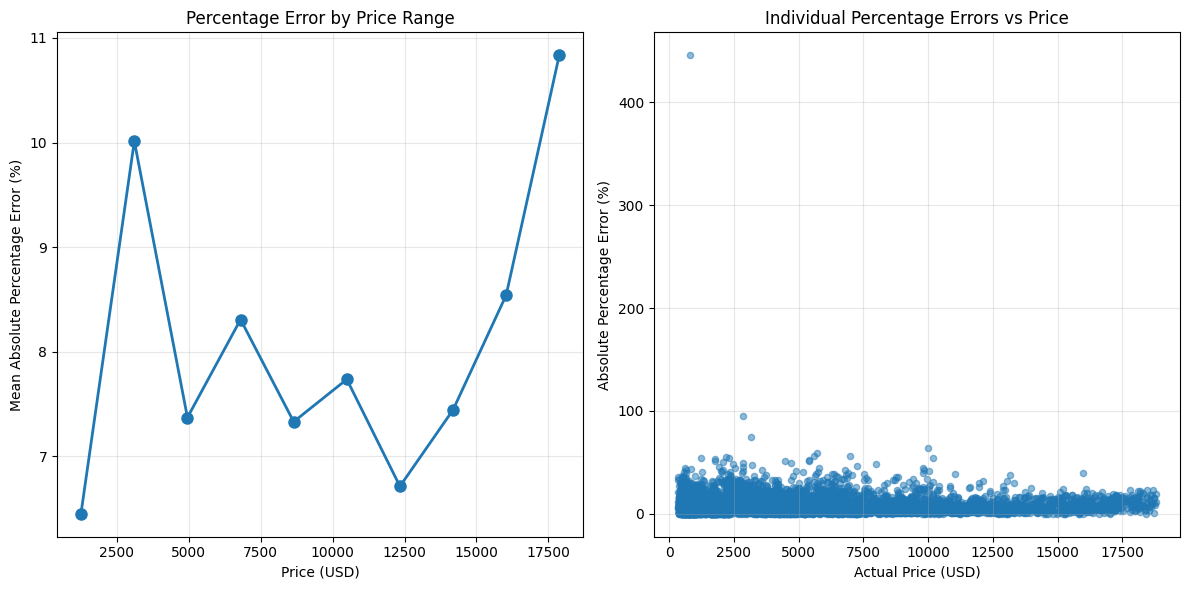


Percentage Error Summary:
Overall MAPE: 7.54%
MAPE for diamonds < $5,000: 7.35%
MAPE for diamonds $5,000-$10,000: 8.11%
MAPE for diamonds > $10,000: 7.88%


In [24]:
# Plot percentage error by price
percentage_errors, bin_centers_actual, bin_errors = plot_percentage_error_by_price(y_test_held_out, results['predictions'])

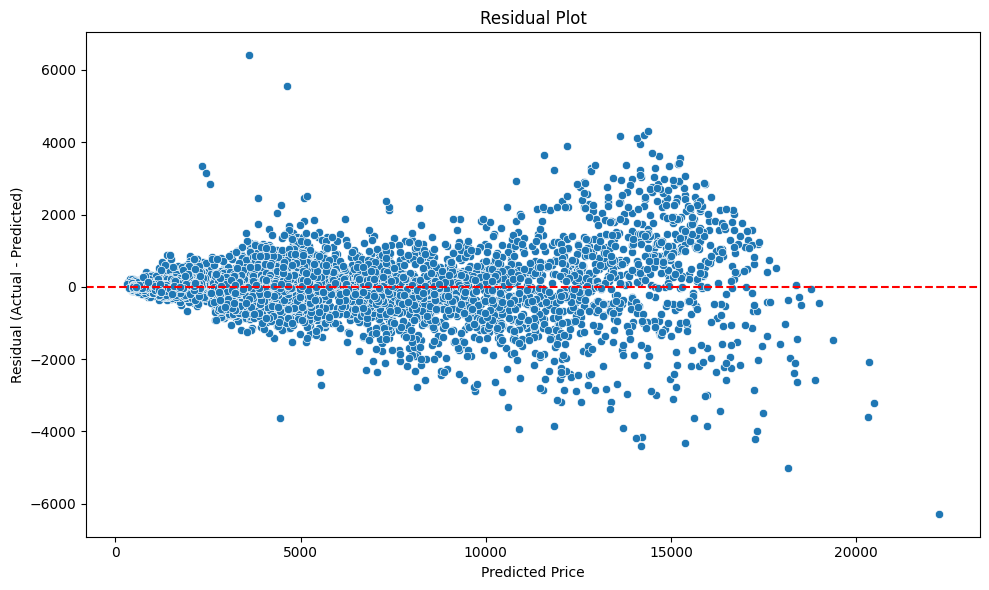

In [23]:
residual_plot(y_test_held_out, results['predictions'])